# Energy and Buildings Paper V2

### Functions
All the subcomponents of the model
* Commerially Available Power Station
* Con Ed Network Data
* PV Performance Modeling
* Grid Electricity Costs
* Hardware Costs
* Max Automated DR Participation

### Loop
Generating all the hardware variations

### Filtering
Filtering hardware variations based on
* ROI

### Analysis

## To Do
* consider inflation in avoided costs
* check official method for TEA

In [2]:
import pandas as pd
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime

In [3]:
#GLOBALS

lat = 40.7128
long = -74.0060

#optimize for summer when DR program is in effect
#also minimizes shading from buildings during PSH
tilt = math.floor(lat - 15)

#default to south facing
azimuth = 180

#14% losses
shading = .86

#max 99% efficient mppt battery charger
mppt = .99

#max 80% depth of discharge for LiFePO4 batteries
LiFePOdod = .8

NREL_API_KEY = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'

#Max Hardware Sizes
#500 is an estimate for the largest array someone can relatively easily install without a professional
pvMaxW = 500
#2kWh is the largest system FDNY allows without additional beurocracy 
batMaxWh = 2000

## Commercially Available Power Station Data


In [4]:
# read in hardware data to dataframe
#hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV19.csv')

hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV22.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Battery Type','App Control','Bypass Mode','Min PV Voltage'
                                        , 'Warranty Years','Lifespan'])

priceDate = '(11/20/2023)'

#filter out batteries over 2kW (this is only needed to increase sample size when looking for representative system)
#print(hardware_df[hardware_df['Battery Wh'] > 2000])
hardware_df = hardware_df[hardware_df['Battery Wh'] <= 2000]

print(hardware_df.shape)
hardware_df.head()

(44, 17)


,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Voltage,Max PV Amps,Inverter Watts,Max AC Input Amps,Max AC Input Watts,Inverter Efficiency,Retail Price (11/12/2023),Price per Wh (11/12/2023),Full Price (11/20/2023),Price per Wh (11/20/2023),Cycles,DoD
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,27.0,5.0,300,5.0,100.0,85.0,254.0,0.88,299.99,1.04,3000,80.0
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,60.0,11.0,1000,15.0,1800.0,85.0,399.0,0.59,799.00,1.17,4000,70.0
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,60.0,22.0,2000,15.0,1800.0,85.0,899.0,0.71,1199.00,0.95,4000,70.0
4,Pecron,E600LFP,614.00,400,0.651466,18.0,7.0,1200,NaN,NaN,85.0,299.0,0.49,499.00,0.81,3500,80.0
5,Pecron,E1500LFP Expandable,1536.00,800,0.520833,18.0,7.0,2200,NaN,NaN,85.0,899.0,0.59,1299.00,0.85,3500,80.0


In [5]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(hardware_df.shape[0]))

#hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')
print('')
print('*** Wh ***')
print('Min:' + str(min(hardware_df['Battery Wh'])))
print('Max:' + str(max(hardware_df['Battery Wh'])))
print('Median:' + str(hardware_df['Battery Wh'].median()))

print('')
print('*** W ***')
print('Min:' + str(min(hardware_df['Max PV Watts'])))
print('Max:' + str(max(hardware_df['Max PV Watts'])))
print('Median:' + str(hardware_df['Max PV Watts'].median()))

print('')
print('*** W/Wh ***')
print('Min:' + str(min(hardware_df['W to Wh Ratio'])))
print('Max:' + str(max(hardware_df['W to Wh Ratio'])))
print('Median:' + str(hardware_df['W to Wh Ratio'].median()))

print('')
print('*** Wh/$ ' + priceDate + '***')
print('Min:' + str(min(hardware_df['Price per Wh ' + priceDate])))
print('Max:' + str(max(hardware_df['Price per Wh ' + priceDate])))
print('Median:' + str(hardware_df['Price per Wh ' + priceDate].median()))

print('')
print('*** Cycles ***')
print('Min:' + str(min(hardware_df['Cycles'])))
print('Max:' + str(max(hardware_df['Cycles'])))
print('Median:' + str(hardware_df['Cycles'].median()))

print('')
print('*** Inv Eff ***')
print('Min:' + str(min(hardware_df['Inverter Efficiency'])))
print('Max:' + str(max(hardware_df['Inverter Efficiency'])))
inverterEfficiencyMed = hardware_df['Inverter Efficiency'].median() * .01
print('Median:' + str(inverterEfficiencyMed))



Total Number of Companies: 16
Total Number of Products: 44

*** Wh ***
Min:99.9
Max:2000.0
Median:995.2

*** W ***
Min:40
Max:1200
Median:270.0

*** W/Wh ***
Min:0.1015625
Max:0.8811090226
Median:0.37005070664999995

*** Wh/$ (11/20/2023)***
Min:0.52
Max:1.73
Median:0.94

*** Cycles ***
Min:2000
Max:6000
Median:3100.0

*** Inv Eff ***
Min:85.0
Max:92.0
Median:0.9


## Con Ed Network Data

In [6]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2023-cleaned.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,14:00,18:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,1
4,bronx,southeast bronx,16:00,20:00,2


In [7]:
#returns the network info for a given network
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
def getTierRate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
def getBoroughRate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#returns borough name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

## PV Performance Modeling

In [8]:
#get TMY via API
df_tmy, metadata = pvlib.iotools.get_psm3(
    latitude=lat, longitude=long,
    api_key=NREL_API_KEY,
    email='nathaa@rpi.edu',  # <-- any email works here fine
    names='tmy-2020')
#metadata

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\pvlib\iotools\psm3.py:364: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  'to hide this warning.', pvlibDeprecationWarning)


In [9]:
# make a Location object corresponding to this TMY
location = pvlib.location.Location(name='NYC',
                                   latitude=metadata['Latitude'],
                                   longitude=metadata['Longitude'])

location

Location: 
  name: NYC
  latitude: 40.73
  longitude: -74.02
  altitude: 0
  tz: UTC

In [10]:
#normalize all years to 2022
#remove timezone info #,tzinfo=None
df_tmy.index = df_tmy.index.map(lambda t: t.replace(year=2020))

#uncomment the 30 minute shifts if using data that is right-labeled at hourly intervals!
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = df_tmy.index #- pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
#solar_position.index += pd.Timedelta('30min')

solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-01-01 00:30:00-05:00,161.167644,161.167644,-71.167644,-71.167644,22.397593,-3.190860
2020-01-01 01:30:00-05:00,154.001161,154.001161,-64.001161,-64.001161,54.029306,-3.210673
2020-01-01 02:30:00-05:00,143.834623,143.834623,-53.834623,-53.834623,72.365773,-3.230477
2020-01-01 03:30:00-05:00,132.705852,132.705852,-42.705852,-42.705852,84.714658,-3.250272
2020-01-01 04:30:00-05:00,121.355180,121.355180,-31.355180,-31.355180,94.580427,-3.270057
...,...,...,...,...,...,...
2020-12-31 19:30:00-05:00,121.549755,121.549755,-31.549755,-31.549755,265.621718,-3.441097
2020-12-31 20:30:00-05:00,132.896245,132.896245,-42.896245,-42.896245,275.528481,-3.460697
2020-12-31 21:30:00-05:00,144.009842,144.009842,-54.009842,-54.009842,287.965009,-3.480288
2020-12-31 22:30:00-05:00,154.134861,154.134861,-64.134861,-64.134861,306.489310,-3.499870


In [11]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
parameters = all_parameters['open_rack_glass_polymer']

#list(all_parameters.keys())

def getPOA(t,a):
    #fixed tilt POA
    df_poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=t,
        surface_azimuth=a,
        dni=df_tmy['DNI'],
        ghi=df_tmy['GHI'],
        dhi=df_tmy['DHI'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic')

    #print(df_poa.keys())
    return df_poa

#DC power going in to battery after accounting for shading and equipment derating
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html#
def getPowerYield(p,g,n):
    
    # note the "splat" operator "**" which expands the dictionary "parameters"
    # into a comma separated list of keyword arguments
    cell_temperature = pvlib.temperature.sapm_cell(
        p['poa_global'], df_tmy['Temperature'], df_tmy['Wind Speed'], **parameters)
    
    array_power = pd.DataFrame({
        'power': pvlib.pvsystem.pvwatts_dc(p['poa_global'], cell_temperature, n, g,temp_ref=25.0)
    })

    #yield is actual power going in to battery after losses
    array_power['yield'] = array_power['power'] * shading * mppt
    
    return array_power
    #array_power = pvlib.pvsystem.pvwatts_dc(df_poa['poa_global'], cell_temperature, n, g,temp_ref=25.0)

    #factor in 14% shading losses + 1% mppt losses
    #return array_power * shading * mppt

#convert DC to AC with PV Watts model
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.inverter.pvwatts.html#pvlib.inverter.pvwatts
#args: dc power input, inverter nameplate max AC output, nameplate efficiency
def getACoutput(dcP,maxACW,iE):
    #max dc input required - assuming the nameplate WAC with efficiency accounted for
    dcPMax = maxACW/iE
    #args: dc power input, max dc input capacity, inverter nameplate efficiency
    return pvlib.inverter.pvwatts(dcP, dcPMax,iE)
    
array_power_yield = getPowerYield(getPOA(tilt,azimuth),gamma_pdc, 500)
array_power_yield.head()

,power,yield
2020-01-01 00:30:00-05:00,0.0,0.0
2020-01-01 01:30:00-05:00,0.0,0.0
2020-01-01 02:30:00-05:00,0.0,0.0
2020-01-01 03:30:00-05:00,0.0,0.0
2020-01-01 04:30:00-05:00,0.0,0.0


In [12]:
print(array_power_yield['power'].max())
print(array_power_yield['yield'].max())
#array_power_yield.iloc[2891]

528.5337668968781
449.993649136002


In [13]:
testW = 1000
print(getACoutput(testW,2000,.9))
print(testW*.9)

901.5865933381758
900.0


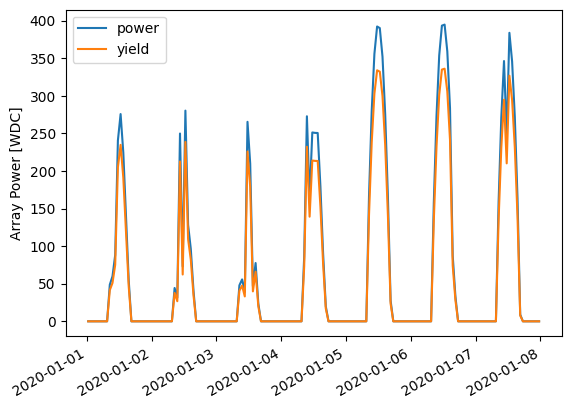

In [14]:
array_power_yield.head(24*7).plot()
plt.ylabel('Array Power [WDC]');

## Grid Electricity Costs

Must add in inflation over 10 years...

In [15]:
# GRID ELECTRICITY COSTS
#Annual Rolling Average is probably best to use here

# source: EIA Electric Power Month, November 2023
# https://www.eia.gov/electricity/monthly/current_month/november2023.pdf
#Average Price of Electricity to Ultimate Customers - Residential - NYS - Year to Date
#septAvgYTDCents = 22.16

#source: https://www.nyserda.ny.gov/Energy-Prices/Electricity/Monthly-Avg-Electricity-Residential
#2023 - January to Sept
monthlyResElecPricesCents = [23.57, 23.60,21.18,19.81,20.47,21.63,22.27,22.33,23.23]
#2022 Oct to Dec
monthlyResElecPricesCents22 = [23.3,23.7,22.8]

monthlyResElecPricesCents.extend(monthlyResElecPricesCents22)
#print(monthlyResElecPrices)

rollingAvgDollars =round((sum(monthlyResElecPricesCents)/len(monthlyResElecPricesCents))* .01,4) 
print('NYS Residential Electricity Rolling Average - September 2023: $' + str(rollingAvgDollars) + '/kWh')

def avoidedUtilityCosts(generatedkWAC):
    
    annualAvoidedCosts = generatedkWAC * rollingAvgDollars
    
    return annualAvoidedCosts

NYS Residential Electricity Rolling Average - September 2023: $0.2232/kWh


## Hardware Costs

In [16]:
# HARDWARE COSTS

'''
I'm looking levelized cost - see NREL's report
'''

# def hardwareCosts(pvW, batWh):
#     #variable hardware costs
#     # average cost of LiFePO4 batteries currently on market
#     # average cost of PV modules per kW
    
#     variableCosts = powerStationPrice(batWh) + (pvW * (pvDollarPerW + mountDollarPerW)) + (cablePerFt * cableRunFt)

#     c = fixedHardwareCosts + variableCosts
#     return c

# print(hardwareCosts(100, 500))

#this is for testing existing battery systems with this model
# def hardwareCostsFixedBattery(pvW):
#     #variable hardware costs
#     # average cost of LiFePO4 batteries currently on market
#     # average cost of PV modules per kW

#     variableCosts = (pvW * (pvDollarPerW + mountDollarPerW))


#     c = fixedHardwareCosts + variableCosts
#     return c

def hardwareCosts(pvW,batPr):
    #variable costs
    pvDollarPerW = 1.0 * .7
    mountDollarPerW = .4
    cablePerFt = .77 * 2 #pos & neg cables 
    cableRunFt = 15

    #fixed costs
    insulation = 4.38
    smartController = 100
    operatingCosts = 0 #DR aggregation operator costs are not considered here. 
    fixedHardwareCosts = smartController + operatingCosts + insulation

    variableCosts = batPr + (pvW * (pvDollarPerW + mountDollarPerW)) + (cablePerFt * cableRunFt)

    return fixedHardwareCosts + variableCosts
#print(hardwareCostsFixedBattery(100))


## Max Automated DR Participation

In [17]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts AC
# i.e. it returns what can automatically be provided per hour for 4 hours during a event in a given month

#get the available hourly watts if the battery is fully depleted over 4 hours
#arg: battery Wh
def getFourHourW(bWh):
    return bWh * LiFePOdod * .25

#args: battery Wh, hourly PV W yield, inverter efficiency, start time, inverter max watts
def maxDRParticipation(batWh, pvWyield,iE,sT,iM):
    #divide by 4 to account for the 4-hour long event window
    #this assumes a full battery at the onset of the event
    batteryACOutput = getACoutput(getFourHourW(batWh),iM,iE)
    #print(batteryACOutput)
    
    runningTot = 0

    #days in the months May - September
    daysInMonth = [31,30,31,31,30]
    
    #returns average WAC generated for all window hours on a monthly basis
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    # do I need to consider leap years?
    elapsedDays = 121
    drEventWhAC_MonthlyAvg = []
    #loop through the months
    for m in range(len(daysInMonth)):
        #print(daysInMonth[m])
        drEventWhAC_DailyAvg = 0
        #loop through days in the month
        for d in range(elapsedDays, elapsedDays +  daysInMonth[m]):
            #print(d)
            drEventWhAC = 0
            #loop through the 4 hours during the event
            for e in range(sT,sT + 4):
                #PV Yield for 1 hour during the event window
                drHour = ((d-1)*24)+e
                #print(getACoutput(pvWyield[drHour],iM,iE))
                drEventWhAC = drEventWhAC + getACoutput(pvWyield[drHour],iM,iE)
            #print(drEventWhAC)
            #get the average for the day
            drEventWhAC_DailyAvg = drEventWhAC_DailyAvg + (drEventWhAC * .25)
        #print((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_MonthlyAvg.append((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_DailyAvg = 0
        elapsedDays = elapsedDays + daysInMonth[m]
    
        #this is average to an hourly basis NOT the total production during the event
        #runningTot = runningTot + (drEventDCWh/4)
    
    numDays = 274-121
    #print(drEventWhAC_MonthlyAvg)
    return drEventWhAC_MonthlyAvg

#uncomment to test
maxDRParticipation(288, array_power_yield['yield'], inverterEfficiencyMed,11,300)

[276.5972079298996,
 278.1730755367503,
 278.97099495130726,
 267.3310197145964,
 254.5871010707783]

## Main Loop

In [18]:
#these networks are selected because they represent all possible combinations of characteristics
myNetworks = ['city hall','long island city','crown heights','randalls island', 'millwood west', 'grasslands','fresh kills','central bronx','northeast bronx']

gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C


In [19]:
# Get ROI for all hardware listed

#loop through all products

#get upfront costs w/ modules

# select network
#network = myNetworks[0]

#nData = {}

rData = {
        'network':[],
        'eventStart':[],
        'az':[],
        'pvW':[],
        'batWh':[],
        'hardwareDollars':[],
        'annualPVkWh':[],
        'annualPVkWhAC':[],
        'avoidedGridCosts':[],
        'maxAutoParticipationMonthlyW':[],
        'maxAutoParticipationW':[],
        'minParticipants':[],
        'totalDRratekW':[],
        'drIncMonthly':[],
        'drIncAnnual':[],
        'annualIncome':[],
        'roi':[],    
        'Cycles':[],
        'lifespan':[],
        'workingLife':[],
        'profitableYears':[],
        'incomeAfterRoi':[],
        'iarSplit':[]
    }

#comment in to test quicker
#myNetworks = ['city hall','long island city','crown heights']

#loop through all networks
for n in myNetworks:
    print(n)

    #loop through all batteries in database
    for b in range(hardware_df.shape[0]):

        #get battery info
        d = hardware_df.iloc[b]
        #print(d)

        #if inverter efficiency data isn't available use median value
        if pd.isnull(d['Inverter Efficiency']):
            invEff = inverterEfficiencyMed
        else:
            invEff = d['Inverter Efficiency'] * .01

        bWh = d['Battery Wh']

        #run this for a quicker test
        #for a in [180]:
        #loop through 3 azimuths
        for a in [110,180,250]:


            #get plane of array irradiance for given azimuth
            poa = getPOA(tilt, a)

            #loop through all allowed PV modules sizes, from 50 to 500 (or max PV capacity if less), incrementing by 10
            for pW in range(50,min(500,d['Max PV Watts'])+10,10):
                rData['network'].append(n)
                rData['eventStart'].append(getStartTime(n))
                rData['az'].append(a)

                array_power_yield = getPowerYield(poa,gamma_pdc, pW)
                #PV Watts
                rData['pvW'].append(pW)
                #Battery Watt Hours
                rData['batWh'].append(bWh)
                #Hardware Costs in Dollars
                hC =hardwareCosts(pW,d['Full Price (11/20/2023)'])
                rData['hardwareDollars'].append(hC)

                #Annual total PV generation kWDC
                pvkWh = array_power_yield['yield'].sum() * .001
                rData['annualPVkWh'].append(pvkWh)

                #convert to AC
                #assumes all PV gets utilized in battery and battery is depleted at 4-hour rate
                fH = getFourHourW(bWh)
                effectiveEfficiency = getACoutput(fH,d['Inverter Watts'],invEff)/fH
                annPvkWh = pvkWh * effectiveEfficiency
                rData['annualPVkWhAC'].append(annPvkWh)

                #total annual avoided grid consumption costs based on AC solar generation
                aGC = avoidedUtilityCosts(annPvkWh)
                rData['avoidedGridCosts'].append(aGC)

                # maximum possible automated hourly DR participation: average available sunlight + 25% of available battery at event start
                maxParW = maxDRParticipation(bWh,array_power_yield['yield'],invEff,getStartTime(n),d['Inverter Watts'])
                rData['maxAutoParticipationMonthlyW'].append(maxParW)
                #the least automated participation at any point in the years is the MAX automation possible
                rData['maxAutoParticipationW'].append(min(maxParW))
                # minimum participants in aggregation if using homogenous systems
                rData['minParticipants'].append(math.ceil(50000 / min(maxParW)))
                #monthly income from DR participation
                #the total DR rate accross both programs
                tDRrkW = getTierRate(n) + getBoroughRate(n)
                rData['totalDRratekW'].append(tDRrkW)
                #monthly income from DR
                monInc= [m * 0.001 * tDRrkW for m in maxParW]
                rData['drIncMonthly'].append(monInc)
                #annual income from DR participation
                drAnnInc = sum(monInc)
                rData['drIncAnnual'].append(drAnnInc)
                #total annual income
                annInc = aGC + drAnnInc
                rData['annualIncome'].append(annInc)
                #print(rData['hardwareDollars'])
                #print(rData['annualIncome'])
                roi = hC/annInc
                rData['roi'].append(roi)
                rData['Cycles'].append(d['Cycles'])
                
                #life span assumes 1 full cycle a day, up to 10 years
                lS = d['Cycles']/365
                rData['lifespan'].append(lS)
                #working life caps the lifespan at 10 years
                wL = min(10,lS)
                rData['workingLife'].append(wL)
                #profitable years is the time between ROI and the end of working life
                pY = max(0,wL - roi)
                rData['profitableYears'].append(pY)
                #income after ROI is the financial benefit during the profitable years
                iar = annInc * pY
                rData['incomeAfterRoi'].append(iar)
                #IAR split across lifespan 
                rData['iarSplit'].append(iar / wL)

    #load data into a DataFrame object:
results_df = pd.DataFrame(rData)
    #nData[n]=productTest_df
print(str(results_df.shape[0])+ ' total hardware combinations generated')


city hall
long island city
crown heights
randalls island
millwood west
grasslands
fresh kills
central bronx
northeast bronx
32589 total hardware combinations generated


In [20]:
ts = datetime.now().timestamp()

results_df.to_csv('results/results_df_' + str(math.floor(ts)) +'.csv')

In [21]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batWh', 'hardwareDollars',
       'annualPVkWh', 'annualPVkWhAC', 'avoidedGridCosts',
       'maxAutoParticipationMonthlyW', 'maxAutoParticipationW',
       'minParticipants', 'totalDRratekW', 'drIncMonthly', 'drIncAnnual',
       'annualIncome', 'roi', 'Cycles', 'lifespan', 'workingLife',
       'profitableYears', 'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [22]:
results_df.head()

,network,eventStart,az,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,avoidedGridCosts,maxAutoParticipationMonthlyW,...,drIncMonthly,drIncAnnual,annualIncome,roi,Cycles,lifespan,workingLife,profitableYears,incomeAfterRoi,iarSplit
0,city hall,11,110,50,288.0,482.47,61.446944,51.325036,11.455748,"[66.43805155540257, 66.86208995712317, 66.6661...",...,"[2.3917698559944927, 2.407035238456434, 2.3999...",11.805982,23.261730,20.740934,3000,8.219178,8.219178,0.0,0.0,0.0
1,city hall,11,110,60,288.0,493.47,73.736333,61.590043,13.746898,"[70.4645545737598, 70.97314493819043, 70.73820...",...,"[2.5367239646553528, 2.5550332177748554, 2.546...",12.500152,26.247049,18.800971,3000,8.219178,8.219178,0.0,0.0,0.0
2,city hall,11,110,70,288.0,504.47,86.025722,71.855050,16.038047,"[74.4890293055557, 75.08208639348501, 74.80832...",...,"[2.6816050550000052, 2.7029551101654605, 2.693...",13.193985,29.232032,17.257439,3000,8.219178,8.219178,0.0,0.0,0.0
3,city hall,11,110,80,288.0,515.47,98.315111,82.120058,18.329197,"[78.51147575079028, 79.18891432300691, 78.8764...",...,"[2.8264131270284505, 2.8508009156282488, 2.839...",13.887480,32.216677,16.000099,3000,8.219178,8.219178,0.0,0.0,0.0
4,city hall,11,110,90,288.0,526.47,110.604500,92.385065,20.620346,"[82.53189390946355, 83.29362872675614, 82.9425...",...,"[2.971148180740688, 2.998570634163221, 2.98593...",14.580687,35.201034,14.956095,3000,8.219178,8.219178,0.0,0.0,0.0


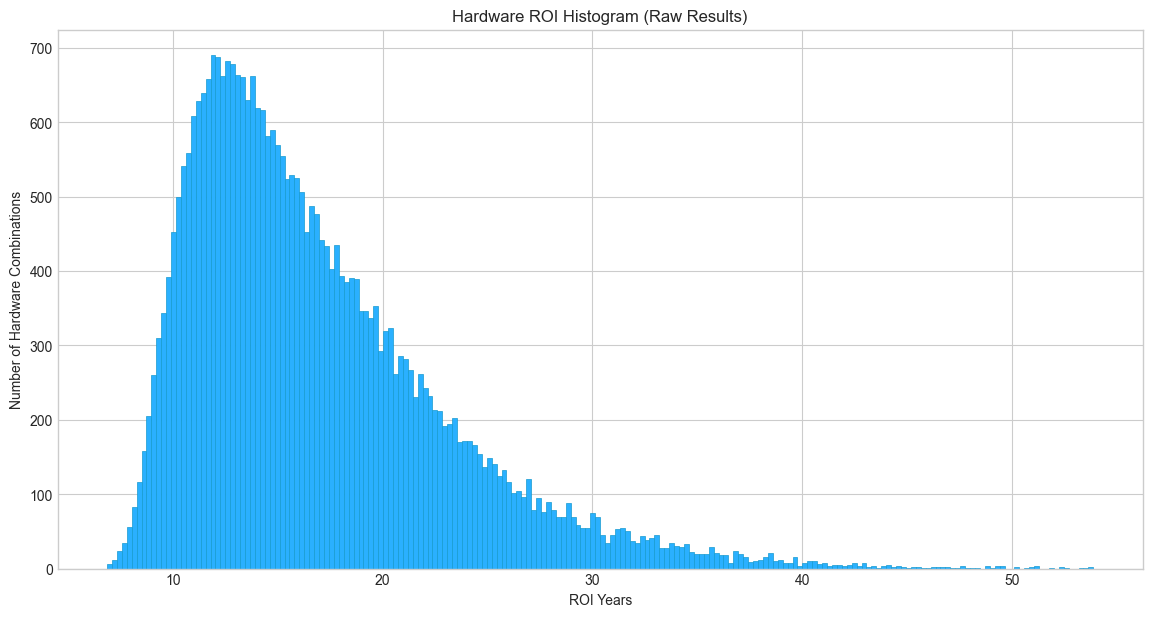

In [23]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(results_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware ROI Histogram (Raw Results)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Filtering

In [24]:
#filter out anything with an ROI over its working years
favROI_df = results_df[results_df['roi'] <= results_df['workingLife']] 

print(str(favROI_df.shape[0])+ ' total favorable ROI hardware combinations generated')
print(str(favROI_df[favROI_df['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated')
print(str(favROI_df[favROI_df['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated')
print(str(favROI_df[favROI_df['az']==250].shape[0])+ ' westerm favorable ROI hardware combinations generated')

1532 total favorable ROI hardware combinations generated
332 eastern favorable ROI hardware combinations generated
721 southern favorable ROI hardware combinations generated
479 westerm favorable ROI hardware combinations generated


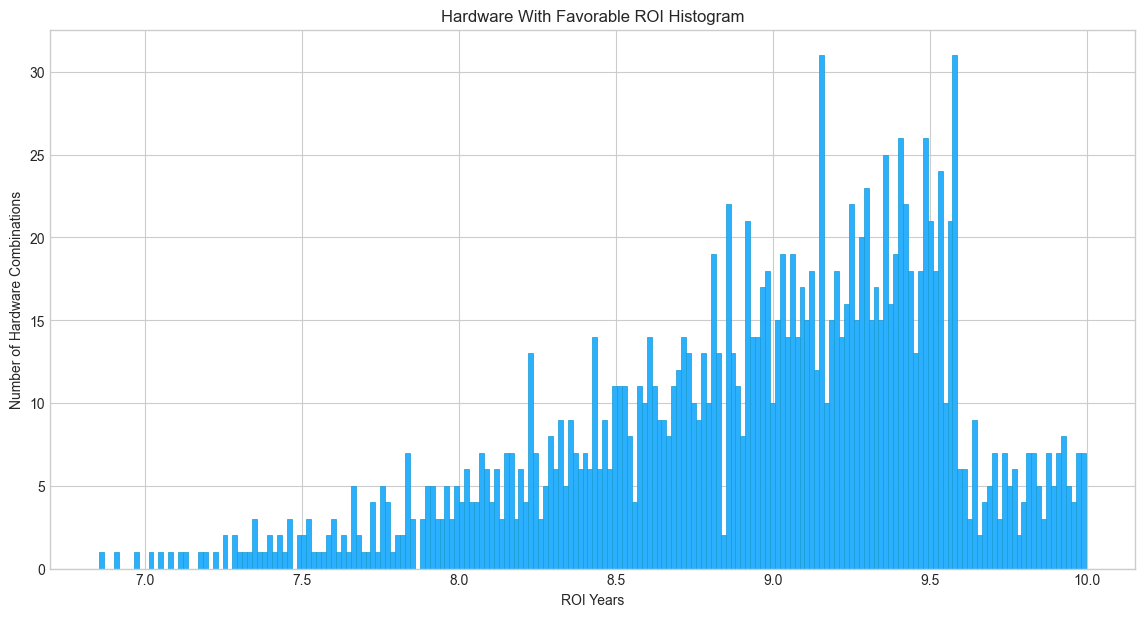

In [25]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

# Analysis

To analize:
* impact of network characteristics
* time and overall quantity
* relationship between azimuth and time

## Overall

* Fastest ROI
* Greatest IAR
* Greatest DR impact
* Greatest PV generation DC
* Greatest avoided grid energy

In [26]:
# fastest ROI
fRoi = favROI_df[favROI_df['roi'] == min(favROI_df['roi'])]
print("Fastest ROI: " + str(fRoi['roi'].iloc[0]) + "yrs")
# slowest ROI
sRoi = favROI_df[favROI_df['roi'] == max(favROI_df['roi'])]
print("Slowest ROI: " + str(sRoi['roi'].iloc[0]) + "yrs")


Fastest ROI: 6.85324473685244yrs
Slowest ROI: 9.996211004833997yrs


Greatest IAR: $580.6243963382954 ($60.550829903850804/per year for 9.58904109589041 years)
Lowest IAR: $0.03402835602865813 ($0.003548671414417205/per year for 9.58904109589041 years)
Amount with 0 IAR: 0


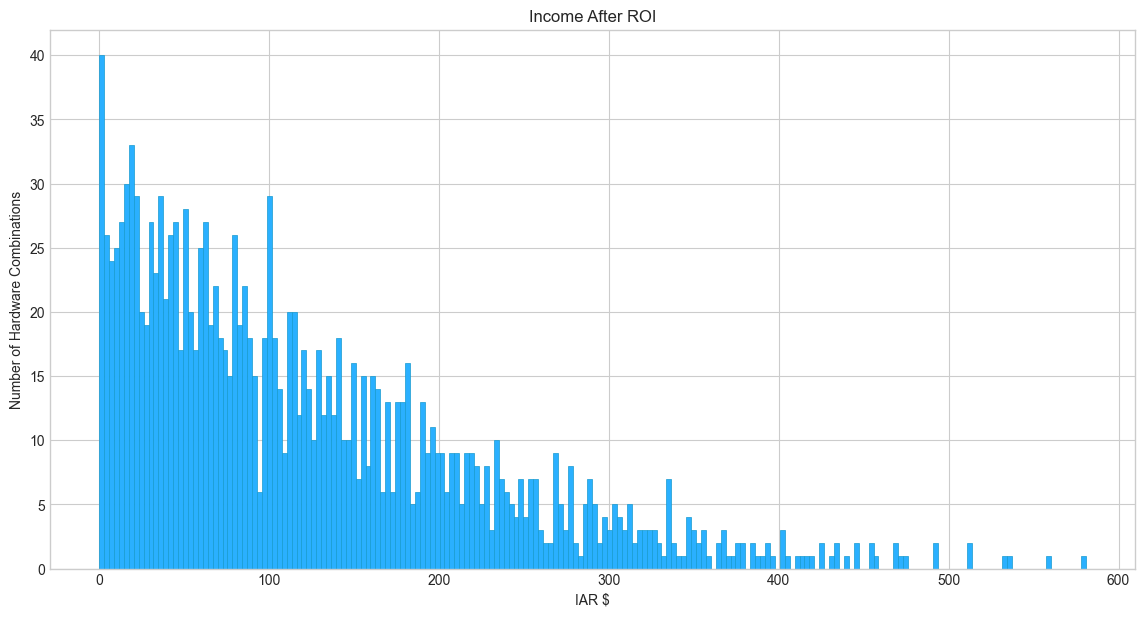

In [27]:
# Income After ROI
maxIAR = favROI_df[favROI_df['incomeAfterRoi'] == max(favROI_df['incomeAfterRoi'])]
print("Greatest IAR: $" + str(maxIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

minIAR = favROI_df[favROI_df['incomeAfterRoi'] == min(favROI_df['incomeAfterRoi'])]
print("Lowest IAR: $" + str(minIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxIAR['lifespan'].iloc[0])) +' years)')

print('Amount with 0 IAR: ' + str(favROI_df[favROI_df['incomeAfterRoi'] == 0].shape[0]))
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Income After ROI') 
plt.xlabel('IAR $') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware w/ IAR >= $300'}, xlabel='batWh', ylabel='pvW'>

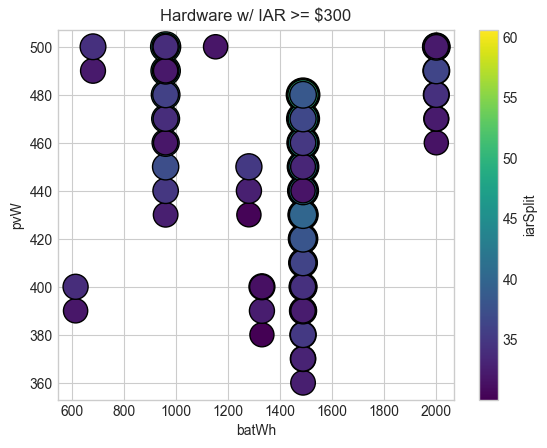

In [28]:
# High IAR

highIAR = favROI_df[favROI_df['incomeAfterRoi'] >= 300]

highIAR.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware w/ IAR >= $300')

# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(highIAR['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Income After ROI ($0 IAR not shown)') 
# plt.xlabel('IAR $') 
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

## Impact of Network Characteristics

Below this point, only favorable ROI combinations are considered.

In [29]:
#myNetworks = ['city hall','long island city','crown heights']

#regardless of azimuth
nFavorable = {
    "name":[],
    "total amount":[],
    "start time":[],
    "dr rate $":[],
    "min PV":[],
    "min PV bat Wh":[], #the battery that pairs with the min PV module
    "max PV":[],
    "max PV bat Wh":[], #the battery that pairs with the max PV module
    "min bat":[],
    "min bat PV W":[], #the PV modules that pair with the min battery
    "max bat":[],
    "max bat PV W":[], #the PV modules that pair with the max battery
    "min cost":[],
    "max cost":[],
    #avg cost is kind of meaningless,
    #because lower call times have both cheaper and most expensive system,
    #so just a wider range of possibilities
    "avg cost":[], 
    "min ROI":[],
    "max ROI":[],
    "avg ROI":[],
    "min IAR":[],
    "max IAR":[],
    "avg IAR":[],
    "min DR":[],
    "max DR":[],
    "avg DR":[]
}
for n in myNetworks:
    tNAz = favROI_df[favROI_df['network'] == n]
    tN = tNAz[tNAz['az'] == 110]
    
    nFavorable['name'].append(n)
    nFavorable['total amount'].append(tN.shape[0])
    
    nFavorable['start time'].append(tNAz.iloc[0]['eventStart'])
    nFavorable['dr rate $'].append(tNAz.iloc[0]['totalDRratekW'])

    if tN.shape[0] != 0:

        #min PV
        tNminMax = tN[tN['pvW'] == min(tN['pvW'])]
        nFavorable['min PV'].append(min(tN['pvW']))
        nFavorable['min PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #max PV
        tNminMax = tN[tN['pvW'] == max(tN['pvW'])]
        nFavorable['max PV'].append(max(tN['pvW']))
        nFavorable['max PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #min BAT
        tNminMax = tN[tN['batWh'] == min(tN['batWh'])]
        nFavorable['min bat'].append(min(tN['batWh']))
        nFavorable['min bat PV W'].append(list(set(tNminMax['pvW'])))

        #max BAT
        tNminMax = tN[tN['batWh'] == max(tN['batWh'])]
        nFavorable['max bat'].append(max(tN['batWh']))
        nFavorable['max bat PV W'].append(list(set(tNminMax['pvW'])))

        nFavorable['min cost'].append(min(tN['hardwareDollars']))
        nFavorable['max cost'].append(max(tN['hardwareDollars']))
        nFavorable['avg cost'].append(tN['hardwareDollars'].mean())
        nFavorable['min ROI'].append(min(tN['roi']))
        nFavorable['max ROI'].append(max(tN['roi']))
        nFavorable['avg ROI'].append(tN['roi'].mean())
        nFavorable['min IAR'].append(min(tN['incomeAfterRoi']))
        nFavorable['max IAR'].append(max(tN['incomeAfterRoi']))
        nFavorable['avg IAR'].append(tN['incomeAfterRoi'].mean())

        nFavorable['min DR'].append(min(tN['maxAutoParticipationW']))
        nFavorable['max DR'].append(max(tN['maxAutoParticipationW']))
        nFavorable['avg DR'].append(tN['maxAutoParticipationW'].mean())
    else:
        for k in ['min PV','min PV bat Wh',
                  'max PV','max PV bat Wh','min bat','min bat PV W','max bat','max bat PV W',
                  'min cost','max cost','avg cost','min ROI','max ROI',
                  'avg ROI','min IAR','max IAR','avg IAR','min DR','max DR','avg DR']:
            nFavorable[k].append(0)

networkResults_df = pd.DataFrame.from_dict(nFavorable)
print(networkResults_df.shape[0])
networkResults_df
# ['network', 'eventStart', 'az', 'pvW', 'batWh', 'hardwareDollars',
#        'annualPVkWh', 'annualPVkWhAC', 'avoidedGridCosts',
#        'maxAutoParticipationMonthlyW', 'maxAutoParticipationW',
#        'minParticipants', 'totalDRratekW', 'drIncMonthly', 'drIncAnnual',
#        'annualIncome', 'roi', 'Cycles', 'lifespan', 'profitableYears',
#        'incomeAfterRoi', 'iarSplit'],

9


,name,total amount,start time,dr rate $,min PV,min PV bat Wh,max PV,max PV bat Wh,min bat,min bat PV W,...,avg cost,min ROI,max ROI,avg ROI,min IAR,max IAR,avg IAR,min DR,max DR,avg DR
0,city hall,117,11,36,210,[992.0],500,"[680.96, 960.0, 1152.0, 2000.0]",614.0,"[320, 290, 390, 360, 330, 300, 400, 370, 340, ...",...,1436.779145,7.399032,9.965572,8.906102,2.034201,430.505503,132.216835,184.825683,518.289633,348.866482
1,long island city,37,14,36,330,[1488.0],500,"[2000.0, 960.0]",614.0,"[390, 360, 400, 370, 380]",...,1397.182703,8.235655,9.994408,9.164198,0.802081,239.018438,76.053165,131.700512,401.360804,263.512066
2,crown heights,12,16,36,380,[1488.0],500,[960.0],960.0,[500],...,1405.896667,8.744980,9.539375,9.147599,7.687146,140.385647,69.665348,176.326922,267.738308,259.228997
3,randalls island,10,19,36,390,[1488.0],480,[1488.0],1488.0,"[480, 450, 420, 390, 460, 430, 400, 470, 440, ...",...,1404.980000,8.909230,9.579541,9.230192,1.344216,110.982824,56.163520,262.292236,262.292236,262.292236
4,millwood west,24,11,24,360,[614.0],500,"[680.96, 960.0]",614.0,"[390, 360, 400, 370, 380]",...,1341.563333,8.569258,9.929865,9.186756,0.923766,173.090082,64.016953,211.317021,419.840884,336.358396
5,grasslands,4,14,24,450,[1488.0],480,[1488.0],1488.0,"[480, 450, 460, 470]",...,1437.980000,9.298591,9.570155,9.432812,2.805151,45.432038,24.118578,304.087245,307.502428,305.794583
6,fresh kills,0,16,24,0,0,0,0,0.0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,central bronx,92,14,43,210,[992.0],500,"[680.96, 960.0, 1152.0, 2000.0]",614.0,"[320, 390, 360, 330, 400, 370, 340, 380, 350]",...,1446.306087,7.720817,9.996211,9.100549,0.137442,351.943838,96.537879,127.390626,401.360804,270.487075
8,northeast bronx,36,16,43,310,[1488.0],500,"[2000.0, 960.0]",614.0,"[400, 390]",...,1444.646667,8.259485,9.979292,9.175951,3.364739,234.132448,75.912258,103.884471,360.319697,251.476074


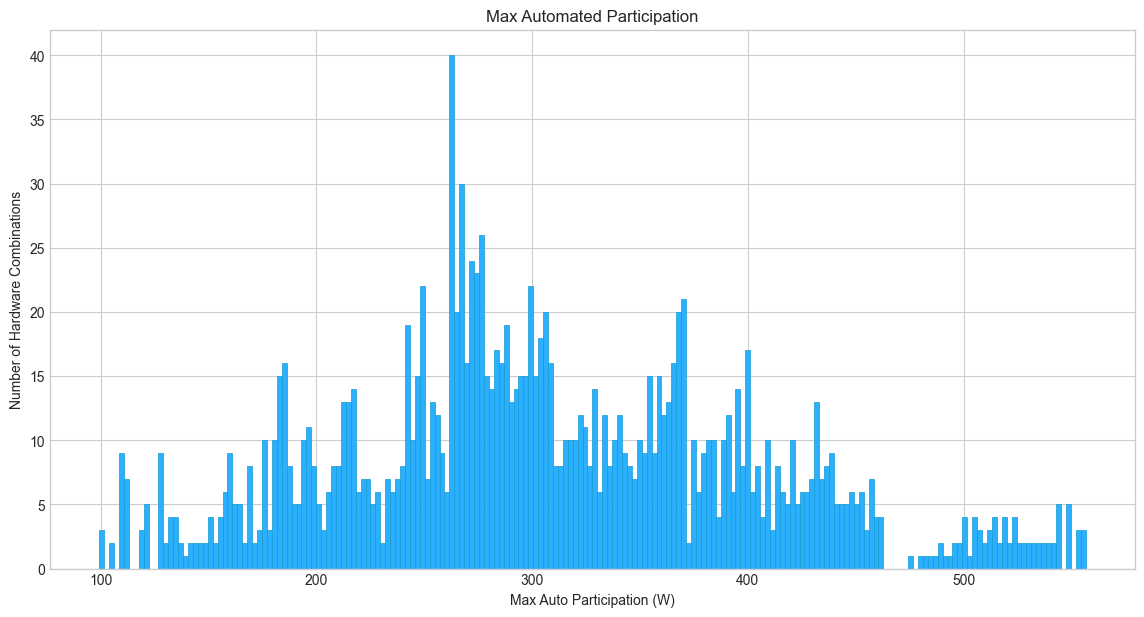

In [31]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['maxAutoParticipationW'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Max Automated Participation') 
plt.xlabel('Max Auto Participation (W)') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [246]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

# bPD = favROI_df[favROI_df['az'] == 250]
    
# boxPlotData = {}
# for n in myNetworks:
#     bP = bPD[bPD['network'] == n]
#     #print(bP['maxAutoParticipationW'].head())
#     #the full label thing doesn't work when some results are 0
#     #print(type(list(bP['maxAutoParticipationW'])))
#     boxPlotData[n]=bP['maxAutoParticipationW']# + "\n("+ str(bP.iloc[0]['eventStart']) + ", $" + str(bP.iloc[0]['totalDRratekW']) +")"]=bP['maxAutoParticipationW']

# boxPlot_df = pd.DataFrame.from_dict(boxPlotData)
# boxPlot_df.boxplot(figsize=(14,7))

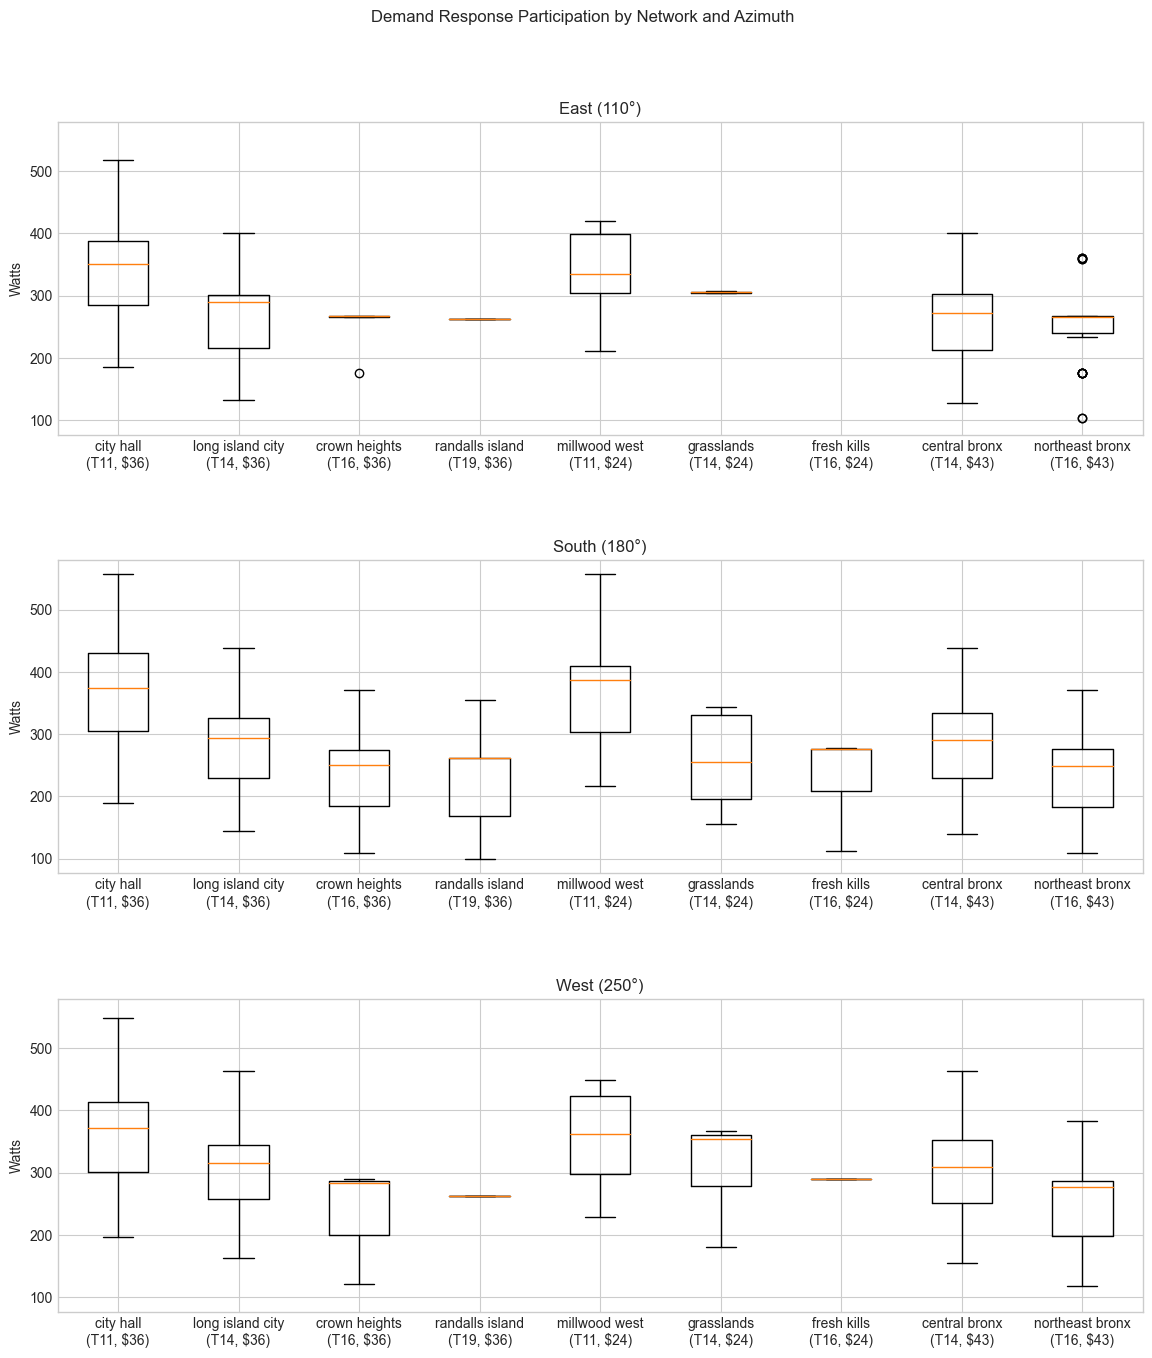

In [247]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df[favROI_df['az'] == 180][favROI_df[favROI_df['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(mN.iloc[0]['eventStart']) + ", $" + str(mN.iloc[0]['totalDRratekW']) +")")

for a in range(3):
    bPD = favROI_df[favROI_df['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['maxAutoParticipationW']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('Demand Response Participation by Network and Azimuth')
    
plt.show()


<AxesSubplot:title={'center':'Max Auto Participation'}, xlabel='maxAutoParticipationW', ylabel='eventStart'>

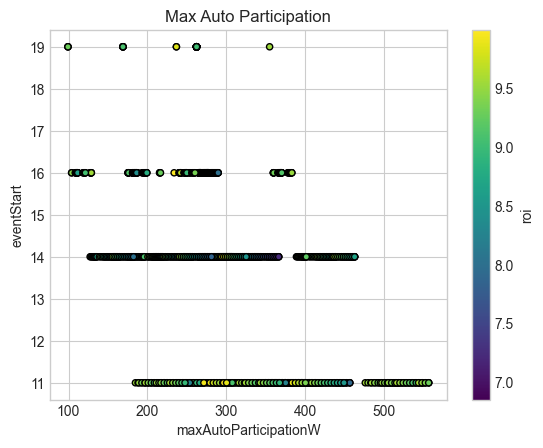

In [32]:
favROI_df.plot(kind = 'scatter', x = 'maxAutoParticipationW', y = 'eventStart', c='roi',edgecolor='black',colormap='viridis', title='Max Auto Participation')


<AxesSubplot:title={'center':'Income After ROI'}, xlabel='incomeAfterRoi', ylabel='eventStart'>

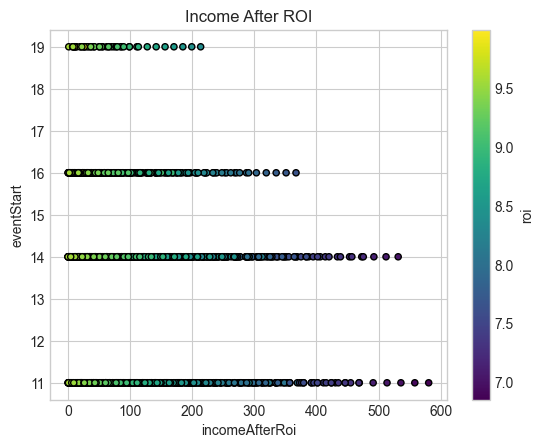

In [33]:
favROI_df.plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'eventStart', c='roi',edgecolor='black',colormap='viridis', title='Income After ROI')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

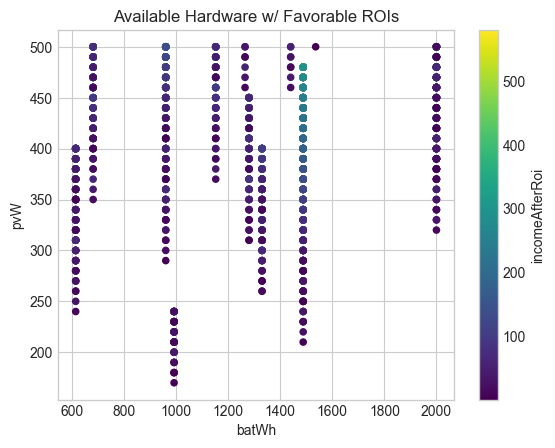

In [34]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


<AxesSubplot:title={'center':'Relationship between IAR and DR Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='maxAutoParticipationW'>

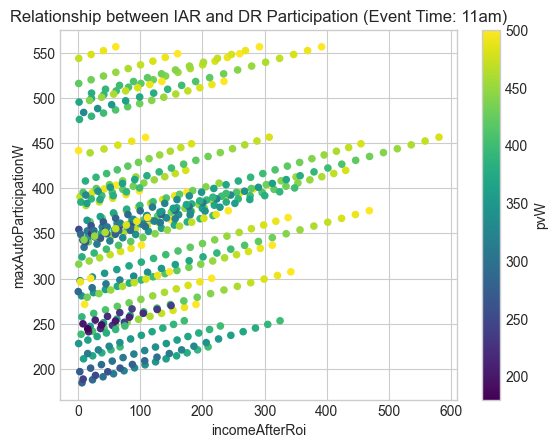

In [35]:
favROI_df[favROI_df['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'maxAutoParticipationW', c='pvW',colormap='viridis', title='Relationship between IAR and DR Participation (Event Time: 11am)')


In [36]:
highParticipation_df = favROI_df[favROI_df['maxAutoParticipationW']>=400]
highParticipation_df.shape[0]

256

<AxesSubplot:title={'center':'Max Auto Participation > 400W'}, xlabel='maxAutoParticipationW', ylabel='eventStart'>

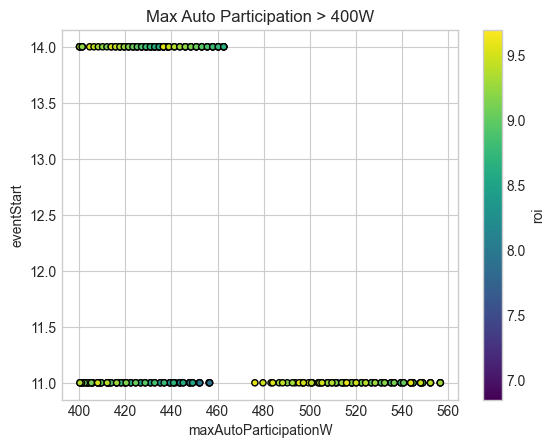

In [37]:
highParticipation_df.plot(kind = 'scatter', x = 'maxAutoParticipationW', y = 'eventStart', c='roi',edgecolor='black',colormap='viridis', title='Max Auto Participation > 400W')


<AxesSubplot:title={'center':'Available Hardware w/ DR Impact > 400W'}, xlabel='batWh', ylabel='pvW'>

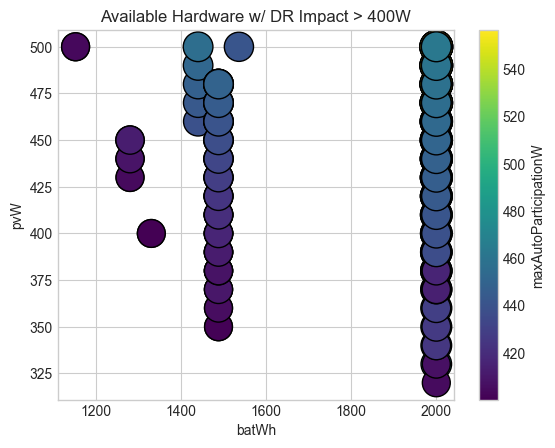

In [38]:
highParticipation_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='maxAutoParticipationW',s='maxAutoParticipationW',edgecolor='black',colormap='viridis', title='Available Hardware w/ DR Impact > 400W')


## Loads


### Typical Appliances

#### Fixed
* Refrigerator

#### Behavior Dependent
Note that baselines are determined by X, so random loads that aren't used at generally the same time each day wouldn't be considered.
* AC
* Fan
* Lamp
* Overhead lights
* Computer
* Electric Stove
* Convection stove

In [39]:
# Typical refrigerator
# source: https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-refrigerator-use/#:~:text=A%20home%20refrigerator's%20power%20consumption,amps%20and%20about%20120%20volts.
fridgeDutyCycle = .333

fridgeMaxW = 800 * fridgeDutyCycle
fridgeMinW = 300 * fridgeDutyCycle
print('Fridge Watts')
print('Max: ' + str(fridgeMaxW) + 'W (' + str(fridgeMaxW * 24) + ' Wh/day)')
print('Min: ' + str(fridgeMinW) + 'W (' + str(fridgeMinW * 24) + ' Wh/day)')


Fridge Watts
Max: 266.40000000000003W (6393.6 Wh/day)
Min: 99.9W (2397.6000000000004 Wh/day)


## Final Analysis

Compare to Nest thermostat